In [1]:
import Models
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_renal_data = pd.read_csv('./x_exp_renal.csv', sep='\t') # Dataset has Donor ID as first column
y_renal_data = pd.read_csv('./y_renal.csv', sep=',') # Dataset has Donor ID on first column and Label on second column.

X_train_norm, X_train_swapped, X_test_norm, y_train, y_test, y_train_oh, y_test_oh, X_train_first, X_train_second, X_swapped_first, X_swapped_second, X_test_first, X_test_second \
    = Models.prepare_datasets(X_renal_data.iloc[:,1:],y_renal_data["label"], test_size=0.2, swap_noise=0.15)


swapping: 65 rows.


In [19]:
import importlib
importlib.reload(Models)

<module 'Models' from 'C:\\Desarrollo\\Data Science\\Jupyter Notebooks\\Stage\\oss-stage-2019\\Singleomic Dataset\\Models.py'>

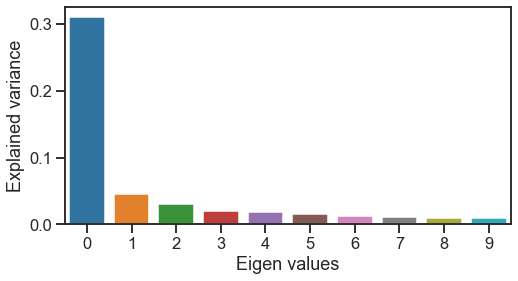

PCA on single-modal explained variance ratio: 0.48103795292302987


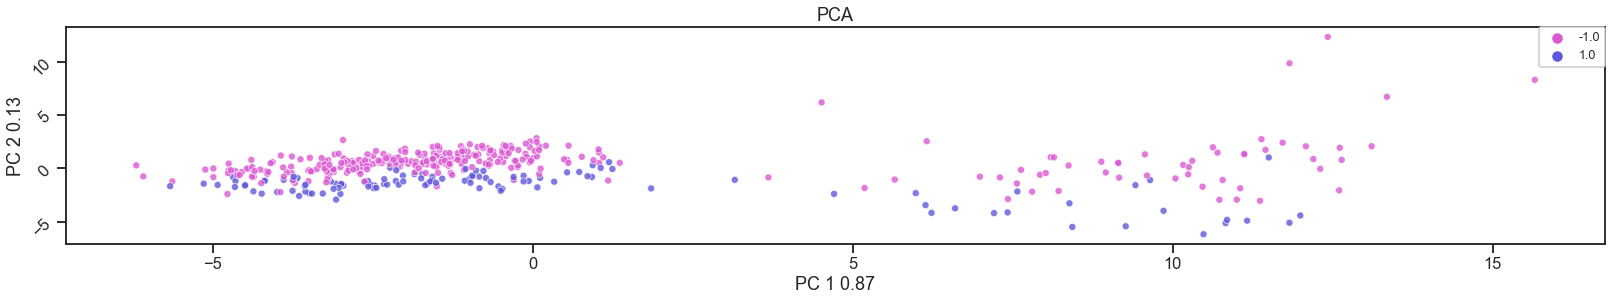

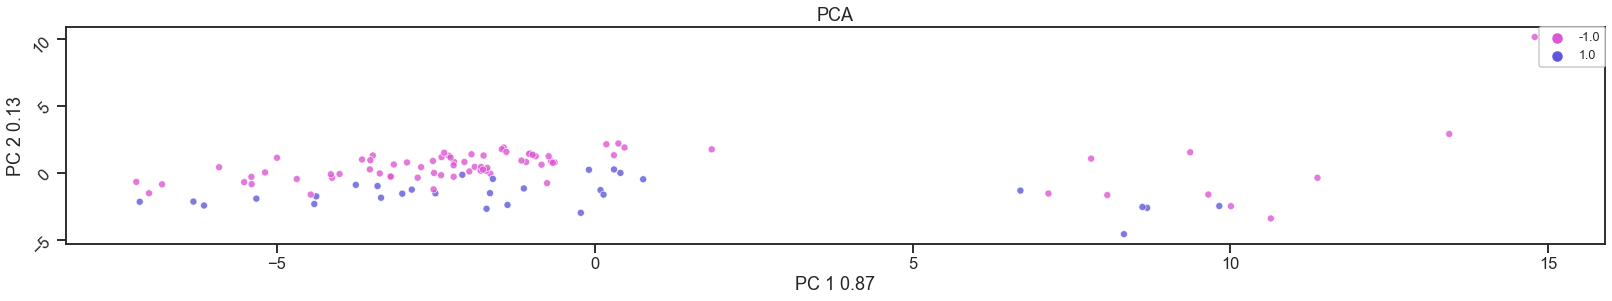

Compression: 102.52
Train on 433 samples
Epoch 1/200
433/433 [==============================] - 2s 4ms/sample - loss: 0.2687 - model_54_loss: 0.1439 - model_54_1_loss: 0.1496 - model_54_mse: 0.1454 - model_54_1_mse: 0.1510
Epoch 2/200
433/433 [==============================] - 1s 1ms/sample - loss: 0.1580 - model_54_loss: 0.0600 - model_54_1_loss: 0.0723 - model_54_mse: 0.0610 - model_54_1_mse: 0.0735
Epoch 3/200
433/433 [==============================] - 1s 1ms/sample - loss: 0.0956 - model_54_loss: 0.0217 - model_54_1_loss: 0.0257 - model_54_mse: 0.0219 - model_54_1_mse: 0.0260
Epoch 4/200
433/433 [==============================] - 1s 2ms/sample - loss: 0.0704 - model_54_loss: 0.0132 - model_54_1_loss: 0.0138 - model_54_mse: 0.0133 - model_54_1_mse: 0.0138
Epoch 5/200
433/433 [==============================] - 1s 2ms/sample - loss: 0.0575 - model_54_loss: 0.0115 - model_54_1_loss: 0.0116 - model_54_mse: 0.0115 - model_54_1_mse: 0.0116
Epoch 6/200
433/433 [============================

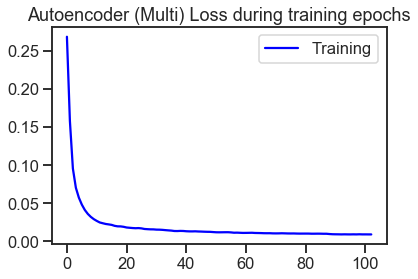

0.009190990712158124


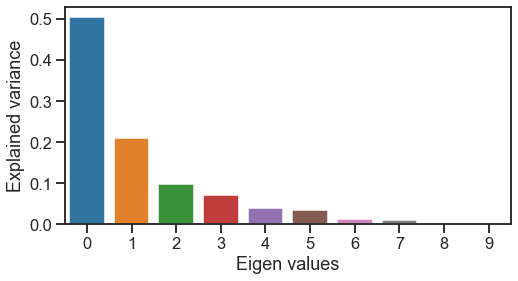

PCA on single-modal explained variance ratio: 0.9872713685035706


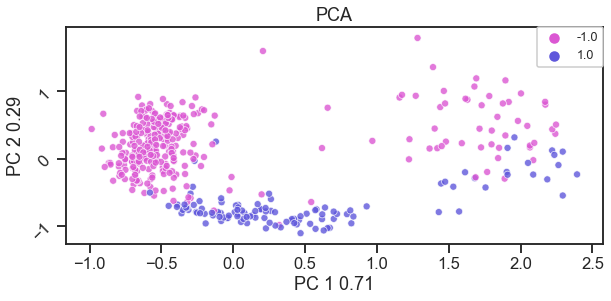

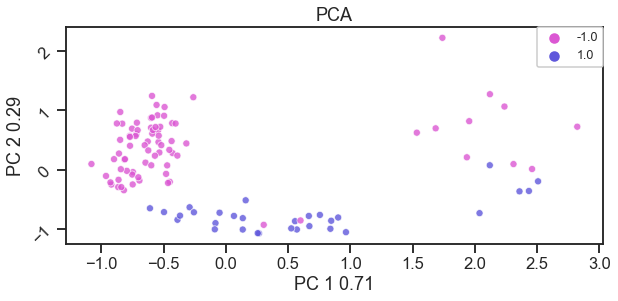

Results for AE: 



C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ZeroDivisionError: float division by zero

  FitFailedWarning)
C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\sklearn\model_selection\_validation.py:536: F

Best score for training data: 0.9677091686714782 

Best C: 0.5 



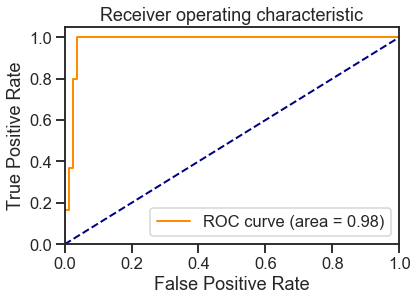

[[76  3]
 [ 2 28]]


              precision    recall  f1-score   support

          -1       0.97      0.96      0.97        79
           1       0.90      0.93      0.92        30

    accuracy                           0.95       109
   macro avg       0.94      0.95      0.94       109
weighted avg       0.95      0.95      0.95       109

Training set score for Logistic Regression: 0.972286
Testing  set score for Logistic Regression: 0.954128
Best score for training data: 0.9677358994921145 

Best C: 0.5 

Best Gamma: 0.1 



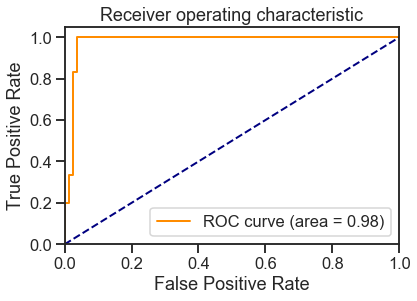

[[76  3]
 [ 2 28]]


              precision    recall  f1-score   support

          -1       0.97      0.96      0.97        79
           1       0.90      0.93      0.92        30

    accuracy                           0.95       109
   macro avg       0.94      0.95      0.94       109
weighted avg       0.95      0.95      0.95       109

Training set score for SVM: 0.974596
Testing  set score for SVM: 0.954128
Best score for training data: 0.9607591553060679 

Best #estimators: 100 

Best max depth: 10 



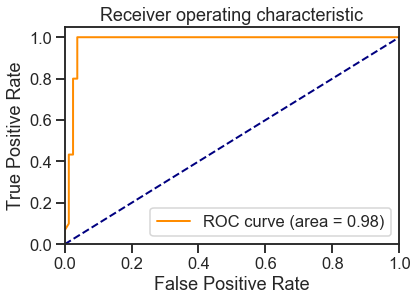

[[76  3]
 [ 3 27]]


              precision    recall  f1-score   support

          -1       0.96      0.96      0.96        79
           1       0.90      0.90      0.90        30

    accuracy                           0.94       109
   macro avg       0.93      0.93      0.93       109
weighted avg       0.94      0.94      0.94       109

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.944954
mutual information: 0.001262014740934313
AE 2 clusters -  silhoutte score: 0.5312510132789612
AE 3 clusters -  silhoutte score: 0.40923836827278137
AE 4 clusters -  silhoutte score: 0.30380314588546753
AE 5 clusters -  silhoutte score: 0.30324068665504456
AE 6 clusters -  silhoutte score: 0.30788829922676086


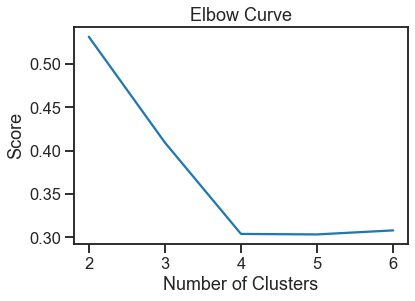

mutual information: 0.004700797981186954
AE 2 clusters -  silhoutte score: 0.560989499092102
AE 3 clusters -  silhoutte score: 0.5337690711021423
AE 4 clusters -  silhoutte score: 0.5073902010917664
AE 5 clusters -  silhoutte score: 0.45247864723205566
AE 6 clusters -  silhoutte score: 0.4031056761741638


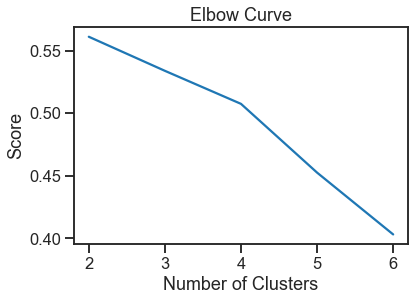

mutual information: 0.00048442643640750696
AE 2 clusters -  silhoutte score: 0.5314267873764038
AE 3 clusters -  silhoutte score: 0.4085354804992676
AE 4 clusters -  silhoutte score: 0.39783409237861633
AE 5 clusters -  silhoutte score: 0.26096269488334656
AE 6 clusters -  silhoutte score: 0.26588326692581177


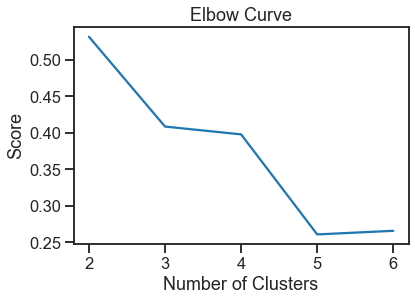

TypeError: can only concatenate list (not "tuple") to list

In [22]:
###  Hyperparamter tuning
# MAP y_train from classes -1 and 1 to 0 and 1
y_train_map = ((y_train + 1)/2).astype(int)

### VISUALIZATION WITH PCA
## ORIGINAL DATASET
X_latent_pca, X_latent_test_pca = Models.perform_PCA(X_train_norm, X_test_norm, y_train, y_test, n_components=10)

mus=[0.7]
dropouts = [0.1]
l1s = [0.000005]
l2s = [0.000005]
scores = []
for dropout in dropouts:
    for l1 in l1s:
        for l2 in l2s:
            for mu in mus:
                ## Build and Train Autoencoder
                autoencoder, encoder, decoder, loss = Models.build_and_train_multi_autoencoder([X_swapped_first,X_swapped_second],
                                                                              [X_train_first,X_train_second],
                                                                              encoding_dim=50, 
                                                                              regularizer=tf.keras.regularizers.l1_l2(l1,l2),
                                                                              dropout=dropout,
                                                                              epochs=200,
                                                                              mu=mu)
                ## Encode datasets
                X_latent_ae = Models.encode_dataset([X_train_first,X_train_second], encoder)
                X_latent_test_ae = Models.encode_dataset([X_test_first,X_test_second], encoder)

                ## PCA ON AUTOENCODER LATENT SPACE
                X_latent_pca_ae, X_latent_test_pca_ae = Models.perform_PCA(X_latent_ae, X_latent_test_ae, y_train, y_test, n_components=10)

                ### CLASSIFICATION ###
                classify = Models.classify_with_cv(X_latent_ae, X_latent_test_ae, y_train, y_test, model_type="AE")

                ### CLUSTERING ###
                clustering = Models.cluster(X_latent_ae,y_train_map, model_type="AE")

                scores.append([mu,dropout,l1,l2,loss] + classify + clustering)


In [21]:
scores = pd.DataFrame(scores,
                      columns=["mu","dropout","l1","l2","loss","LR_accuracy","SVM_accuracy", "RF_accuracy", "LR_auc", "SVM_auc", "RF_auc","kmeans_silhouette","kmeans_mutual_info","spectral_silhouette","spectral_mutual_info","hierarchical_silhouette","hierarchical_mutual_info"])    
scores

,mu,dropout,l1,l2,loss,LR_accuracy,SVM_accuracy,RF_accuracy,LR_auc,SVM_auc,RF_auc,kmeans_silhouette,kmeans_mutual_info,spectral_silhouette,spectral_mutual_info,hierarchical_silhouette,hierarchical_mutual_info
0,0.7,0.1,0.000005,0.000005,0.010354,0.944954,0.954128,0.963303,0.977637,0.978059,0.981857,0.480703,0.339049,0.537074,0.001402,0.473048,0.478124


### Results

| dim | mu  | l1      | l2      | Dropout | Loss   | Accuracy (LR) | Accuracy (SVM) | Accuracy (RF) | ROC-AUC (LR) | ROC-AUC (SVM) | ROC-AUC (RF) | SS (K-means) | MI (K-means) | SS (Spectral) | MI (Spectral) | SS (Hierarch.) | MI (Hierarch.) |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 50  | 0.5 | 0.000005| 0.000005| 0.10    | 0.0093 |  0.96         | 0.93           | 0.97          | 0.9814       | 0.9814        | 0.9850       | 0.50         | 0.0004       | 0.51          | 0.0000        | 0.50           | 0.0004         |
| 50  | 0.5 | 0.000005| 0.000001| 0.00    | 0.0106 |  0.96         | 0.96           | 0.94          | 0.9856       | 0.9839        | 0.9873       | 0.41         | 0.4355       | 0.51          | 0.0047        | 0.40           | 0.4112         |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 100 | 0.5 | 0.000005| 0.000001| 0.00    | 0.0087 |  0.95         | 0.94           | 0.98          | 0.9822       | 0.9822        | 0.9824       | 0.55         | 0.0004       | 0.55          | 0.0006        | 0.55           | 0.0004         |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 200 | 0.5 | 0.000005| 0.000001| 0.20    | 0.0101 |  0.96         | 0.95           | 0.97          | 0.9810       | 0.9767        | 0.9852       | 0.55         | 0.0015       | 0.50          | 0.0047        | 0.55           | 0.0004         |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 20  | 0.5 | 0.000005| 0.000005| 0.00    | 0.0120 |  0.93         | 0.92           | 0.94          | 0.9679       | 0.9721        | 0.9706       | 0.43         | 0.4197       | 0.50          | 0.0033        | 0.50           | 0.0003         |
| 20  | 0.5 | 0.000005| 0.000005| 0.10    | 0.0110 |  0.94         | 0.93           | 0.94          | 0.9755       | 0.9780        | 0.9755       | 0.52         | 0.0012       | 0.52          | 0.0012        | 0.52           | 0.0004         |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 50  | 0.5 | 0.000005| 0.000005| 0.10    | 0.0095 |  0.95         | 0.94           | 0.96          | 0.9793       | 0.9793        | 0.9854       | 0.54         | 0.0006       | 0.55          | 0.0047        | 0.54           | 0.0004         |
| 50  | 0.7 | 0.000005| 0.000005| 0.10    | 0.0121 |  0.95         | 0.95           | 0.97          | 0.9797       | 0.9797        | 0.9871       | 0.45         | 0.3095       | 0.51          | 0.0006        | 0.44           | 0.4695         |
|-----|-----|---------|---------|---------|--------|---------------|----------------|---------------|--------------|---------------|--------------|--------------|--------------|---------------|---------------|----------------|----------------|
| 50  | 0.7 | 0.000005| 0.000005| 0.15    | 0.0095 |  0.95         | 0.92           | 0.98          | 0.9810       | 0.9818        | 0.9789       | 0.54         | 0.0008       | 0.53          | 0.0047        | 0.54           | 0.0006         |
| 50  | 0.9 | 0.000005| 0.000005| 0.10    | 0.0115 |  0.94         | 0.95           | 0.96          | 0.9793       | 0.9801        | 0.9793       | 0.51         | 0.0004       | 0.51          | 0.0006        | 0.51           | 0.0003         |
| 50  | 0.9 | 0.000005| 0.000005| 0.15    | 0.0112 |  0.95         | 0.92           | 0.97          | 0.9818       | 0.9831        | 0.9791       | 0.44         | 0.4041       | 0.50          | 0.0008        | 0.44           | 0.4738         |

